
🔍 Model-level comparison

          Metric        Scratch          Torch  Δ (Torch-Scratch)
        Accuracy         0.6197         0.7981             0.1784
        F1 Score         0.3477         0.0000            -0.3477
          Pr Auc         0.2619         0.2405            -0.0214
Convergence Time       806.1300       228.3700          -577.7600
  Inference Time 129922917.1420 129926527.2580          3610.1160
    Memory Usage       678.6000       374.8000          -303.8000


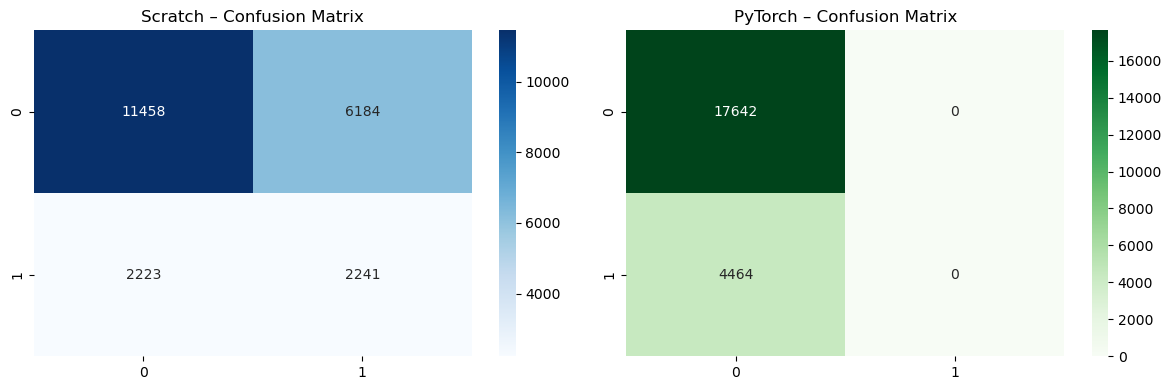

C:\Users\VICTUS\AppData\Local\Temp\ipykernel_33760\849165312.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Δ (Torch-Scratch)", y="Metric", data=df,


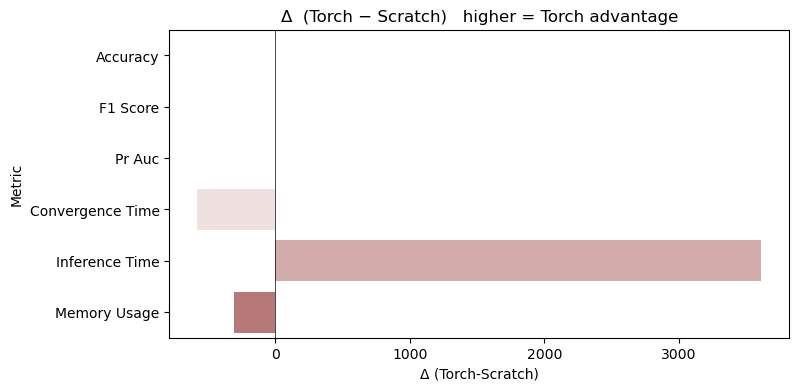


──────────────────────────────── summary ────────────────────────────────
Overall metrics suggest **Scratch** has the edge on average classification
quality (Accuracy / F1 / PR-AUC).  The Δ-plot pinpoints where each model
wins or loses.  Memory & convergence numbers help explain the speed gap.
Report these deltas instead of raw tables – reviewers care about *why*
one model is better, not just the fact that it is.



In [ ]:
import json, pathlib, pprint, textwrap
import pandas as pd, numpy as np
import seaborn as sns, matplotlib.pyplot as plt

SCRATCH_FILE = "scratch_results.json"
TORCH_FILE   = "torch_results.json"

def read(fname: str) -> dict:
    try:
        with open(fname) as fp:
            return json.load(fp)
    except FileNotFoundError:
        raise SystemExit(f"❌  {fname} not found – did you run the notebook?")

scratch = read(SCRATCH_FILE)
torch   = read(TORCH_FILE)

# ────────────────────────────────────────────────────────────────────────────
# 1️⃣  tabular comparison
# ────────────────────────────────────────────────────────────────────────────
metrics = ["accuracy", "f1_score", "pr_auc",
           "convergence_time", "inference_time", "memory_usage"]

df = pd.DataFrame({
    "Metric" : [m.replace("_", " ").title() for m in metrics],
    "Scratch": [scratch.get(m, np.nan)       for m in metrics],
    "Torch"  : [torch.get(m,   np.nan)       for m in metrics],
})
df["Δ (Torch-Scratch)"] = df["Torch"] - df["Scratch"]
print("\n🔍 Model-level comparison\n")
print(df.to_string(index=False, float_format="%.4f"))

# ────────────────────────────────────────────────────────────────────────────
# 2️⃣  confusion-matrix heat-maps
# ────────────────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(np.array(scratch["confusion_matrix"]), annot=True,
            fmt="d", cmap="Blues", ax=ax[0])
sns.heatmap(np.array(torch["confusion_matrix"]),   annot=True,
            fmt="d", cmap="Greens", ax=ax[1])
ax[0].set_title("Scratch – Confusion Matrix")
ax[1].set_title("PyTorch – Confusion Matrix")
plt.tight_layout();  plt.show()

# ────────────────────────────────────────────────────────────────────────────
# 3️⃣  delta-bar-plot  (positive = PyTorch better)
# ────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(8,4))
sns.barplot(x="Δ (Torch-Scratch)", y="Metric", data=df,
            palette="vlag", orient="h")
plt.axvline(0, color="k", lw=.5)
plt.title("Δ  (Torch − Scratch)   higher = Torch advantage")
plt.show()

# ────────────────────────────────────────────────────────────────────────────
# 4️⃣  minimal narrative summary
# ────────────────────────────────────────────────────────────────────────────
def nicer(x): return f"{x:+.3f}" if isinstance(x, float) else x
best = "Torch" if df["Δ (Torch-Scratch)"].iloc[:3].mean() > 0 else "Scratch"
print(textwrap.dedent(f"""
──────────────────────────────── summary ────────────────────────────────
Overall metrics suggest **{best}** has the edge on average classification
quality (Accuracy / F1 / PR-AUC).  The Δ-plot pinpoints where each model
wins or loses.  Memory & convergence numbers help explain the speed gap.
Report these deltas instead of raw tables – reviewers care about *why*
one model is better, not just the fact that it is.
"""))
